In [15]:
from itertools import product

import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os
from sklearn.cluster import KMeans

In [16]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])

In [17]:
def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

In [18]:
class Product:
  def __init__(self, position, width, height, cornerpoints):
    self.position = position
    self.width = width
    self.height = height
    self.cornerpoints = cornerpoints

In [19]:
def find_image(scene_path, model_paths, MIN_MATCH_PERCENTAGE = 13, MIN_MATCH_COUNT=80, GRID_RESOLUTION=25, MIN_VOTES=25):
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    result = []

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        product_result = []

        # Apply model preprocessing
        model_gray = model["img"]

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE/100)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

        if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:
            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)


            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            # assign features matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)

            # select vote winners in grid
            barygrid_means = []
            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))

            ignored_area = []

            for winner, barygrid_mean in zip(winners, barygrid_means):

                # check if Winner is in area with already found winner
                winner_found = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        winner_found = True
                        break
                if winner_found:
                    continue

                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                # Compute height as the average of two height measurements
                height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

                # Compute width as the average of two width measurements
                width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

                # Compute center X coordinate
                x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                         (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

                # Compute center Y coordinate
                y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                         (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

                # Create product object and append to result list
                product_result.append(Product((x, y), width, height, dst))

                #add found instance to ignored areas
                ignored_area.append([o[0] for o in np.int32(dst)])
        result.append(product_result)
    return result


def product_recognition(scene, models, result):
    scene_img = cv.imread(get_path_scene(scene))
    for i in range(len(result)):
        product_results = result[i]
        print(f"Product {models[i]} - {len(product_results)} instance found:")
        for j in range(len(product_results)):
            print("\tInstance {}: position: {}, width: {}px, height: {}px".format(j,
                                                                                  product_results[j].position,
                                                                                  product_results[j].width,
                                                                                  product_results[j].height) )
            cv.rectangle(scene_img,
                         (product_results[j].position[0] - int(product_results[j].width/2),
                          product_results[j].position[1] - int(product_results[j].height/2)),
                         (product_results[j].position[0] + int(product_results[j].width/2),
                          product_results[j].position[1] + int(product_results[j].height/2)),
                         (0,255,0),3)

            #add square and add text
            means = np.mean(product_results[j].cornerpoints, axis=0)
            x, y = [a for a in means[0]]
            x = x * 0.9 #adjust for text
            boldness = 3
            size = 3

            cv.putText(scene_img, str(models[i]), (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)

    plt.imshow(cv.cvtColor(scene_img, cv.COLOR_BGR2RGB))
    plt.show()

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 11 - 0 instance found:
Product 19 - 0 instance found:
Product 24 - 2 instance found:
	Instance 0: position: (184, 213), width: 351px, height: 500px
	Instance 1: position: (550, 218), width: 335px, height: 490px
Product 25 - 0 instance found:
Product 26 - 1 instance found:
	Instance 0: position: (921, 218), width: 333px, height: 486px


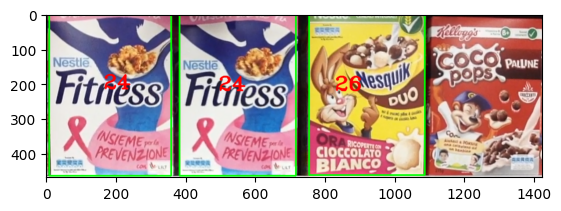

In [20]:
#define models to be searched in image
scene = "m1.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models],
                    MIN_MATCH_PERCENTAGE = 13,
                    MIN_MATCH_COUNT=300,
                    GRID_RESOLUTION=25,
                    MIN_VOTES=25)

product_recognition(scene, models, result)

Product 0 - 1 instance found:
	Instance 0: position: (178, 300), width: 343px, height: 448px
Product 1 - 0 instance found:
Product 11 - 0 instance found:
Product 19 - 0 instance found:
Product 24 - 0 instance found:
Product 25 - 0 instance found:
Product 26 - 0 instance found:


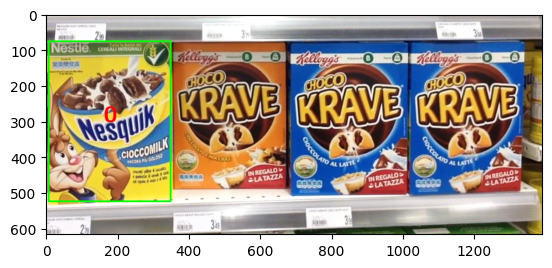

In [21]:
#define models to be searched in image
scene = "m2.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models],
                    MIN_MATCH_PERCENTAGE = 13,
                    MIN_MATCH_COUNT=300,
                    GRID_RESOLUTION=25,
                    MIN_VOTES=25)

product_recognition(scene, models, result)

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 11 - 0 instance found:
Product 19 - 1 instance found:
	Instance 0: position: (1233, 189), width: 295px, height: 382px
Product 24 - 0 instance found:
Product 25 - 0 instance found:
Product 26 - 1 instance found:
	Instance 0: position: (195, 206), width: 354px, height: 506px


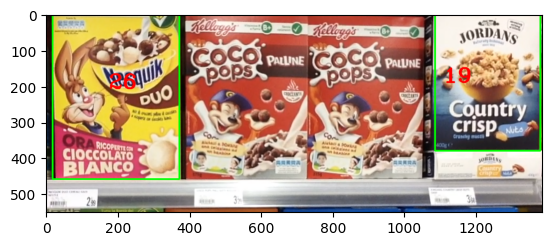

In [22]:
#define models to be searched in image
scene = "m3.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models],
                    MIN_MATCH_PERCENTAGE = 13,
                    MIN_MATCH_COUNT=300,
                    GRID_RESOLUTION=25,
                    MIN_VOTES=25)

product_recognition(scene, models, result)

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 11 - 0 instance found:
Product 19 - 0 instance found:
Product 24 - 2 instance found:
	Instance 0: position: (161, 189), width: 365px, height: 509px
	Instance 1: position: (539, 195), width: 348px, height: 500px
Product 25 - 0 instance found:
Product 26 - 1 instance found:
	Instance 0: position: (921, 195), width: 341px, height: 493px


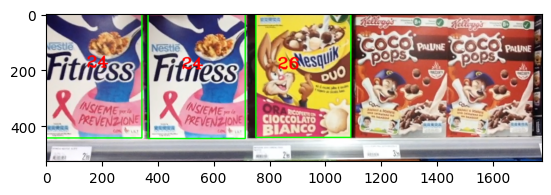

In [23]:
#define models to be searched in image
scene = "m4.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models],
                    MIN_MATCH_PERCENTAGE = 13,
                    MIN_MATCH_COUNT=300,
                    GRID_RESOLUTION=25,
                    MIN_VOTES=25)

product_recognition(scene, models, result)

Product 0 - 0 instance found:
Product 1 - 0 instance found:
Product 11 - 0 instance found:
Product 19 - 1 instance found:
	Instance 0: position: (908, 189), width: 295px, height: 383px
Product 24 - 0 instance found:
Product 25 - 0 instance found:
Product 26 - 0 instance found:


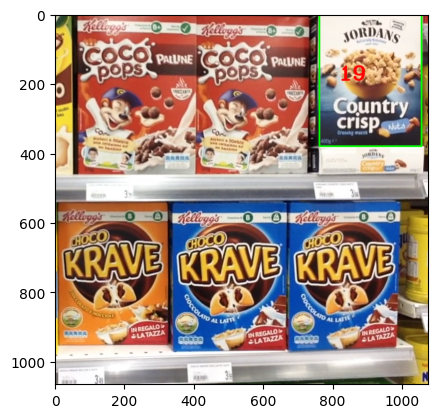

In [24]:
#define models to be searched in image
scene = "m5.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models],
                    MIN_MATCH_PERCENTAGE = 13,
                    MIN_MATCH_COUNT=300,
                    GRID_RESOLUTION=25,
                    MIN_VOTES=25)

product_recognition(scene, models, result)